The aim of this project is to build a model capable of detecting fake images, specifically deepfake images, using a convolutional neural network (CNN). The project leverages TensorFlow and Keras for model creation, training, and evaluation. We use a dataset consisting of images categorized into real and fake classes. The model performs binary classification, classifying each image as either 'real' or 'fake'.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# Defining the path to Dataset.zip in your Google Drive
zip_path = '/content/drive/MyDrive/Dataset.zip'

# Unzipping the file to a desired location /content/Dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset')

In [3]:
# Listing the files in the specified directory '/content/Dataset'.
import os
os.listdir('/content/Dataset')

['Validation', 'Train', 'Test']

In [4]:
# Defining the path to the 'Dataset' directory for further use.
import pathlib
path = '/content/Dataset'

## Loading Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
import os
from concurrent.futures import ThreadPoolExecutor

##Data Preprocessing

We started by loading the image dataset using TensorFlow's image_dataset_from_directory method, which organizes the images into training, validation, and test sets. The images are resized to a consistent size of (128, 128) for input to the model.

In [6]:
# Preprocessing
def get_from_dir(dir):
    dir = os.path.join(path, dir)

    return tf.keras.utils.image_dataset_from_directory(
           dir,                        # Directory containing images
           labels='inferred',          # Automatically infer labels based on folder names
           color_mode="rgb",           # Convert images to RGB color format
           seed=42,                    # Set seed for reproducibility
           batch_size=32,              # Set batch size for loading images
           image_size=(128, 128))      # Resize all images to 128x128 pixels

train = get_from_dir("Train")

test = get_from_dir("Test")

val = get_from_dir("Validation")

Found 140002 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.


In [10]:
# Analyze image size distribution
size_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
print(size_df.describe())

          Width    Height
count  190335.0  190335.0
mean      128.0     128.0
std         0.0       0.0
min       128.0     128.0
25%       128.0     128.0
50%       128.0     128.0
75%       128.0     128.0
max       128.0     128.0


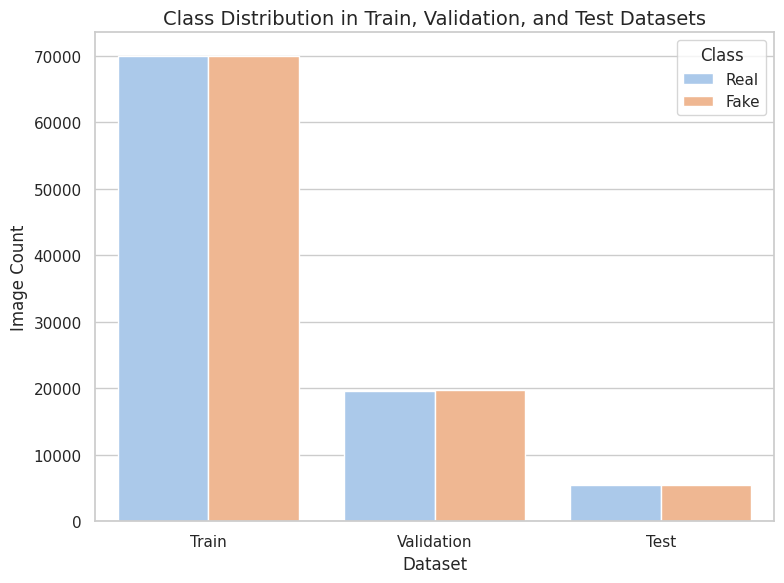

In [12]:
# Visualization
def count_images_in_tf_dataset(dataset):
    real_count = 0
    fake_count = 0

    for _, labels in dataset:  # Loop through batches
        real_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
        fake_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()

    return real_count, fake_count

# Get counts for Train, Validation, and Test datasets
train_real, train_fake = count_images_in_tf_dataset(train)
val_real, val_fake = count_images_in_tf_dataset(val)
test_real, test_fake = count_images_in_tf_dataset(test)

if train_real + train_fake + val_real + val_fake + test_real + test_fake > 0:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    data = {
        'Dataset': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
        'Class': ['Real', 'Fake', 'Real', 'Fake', 'Real', 'Fake'],
        'Count': [train_real, train_fake, val_real, val_fake, test_real, test_fake]
    }
    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Dataset', y='Count', hue='Class', data=df, palette="pastel")
    plt.title('Class Distribution in Train, Validation, and Test Datasets', fontsize=14)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Image Count', fontsize=12)
    plt.legend(title='Class', loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print("No valid counts available for visualization.")


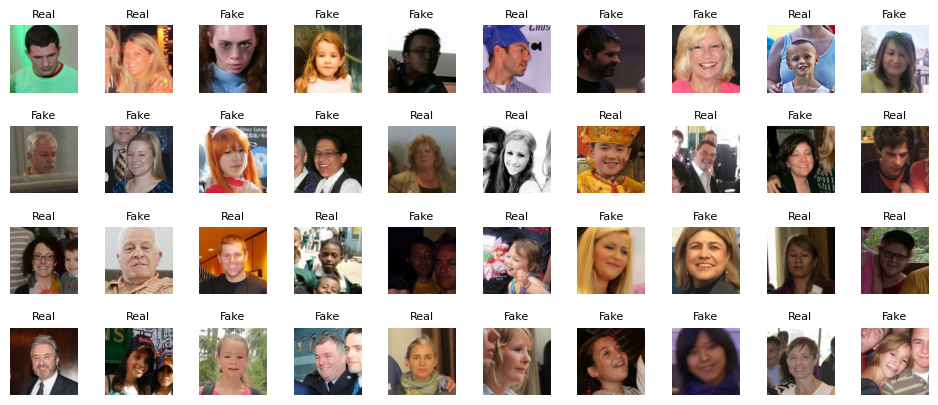

In [ ]:
# Visualizing sample images from the training dataset.
class_names = np.unique(train.class_names)
n_rows, n_cols = 4, 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))


data = list(train.take(n_rows * n_cols))


for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        single_image = data[index][0][0]
        label_index = data[index][1][0]


        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(single_image.numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[label_index], fontsize=8)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

##Convolutional Neural Network (CNN)

The model we used is a Convolutional Neural Network (CNN) consisting of several convolutional and pooling layers, followed by fully connected layers for binary classification. Below is the architecture used:

- Convolutional Layers: Extracts features from images.
- MaxPooling Layers: Reduces spatial dimensions.
- Flatten Layer: Converts the 2D matrix into a 1D vector.
- Dense Layers: Fully connected layers to make the final prediction.
- Dropout Layer: Helps to prevent overfitting.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding='same', input_shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,514,721 (17.22 MB)

 Trainable params: 4,514,721 (17.22 MB)

 Non-trainable params: 0 (0.00 B)

##Model Training

The model was trained using the Adam optimizer and binary cross-entropy loss function.Early stopping was applied to avoid overfitting.

In [ ]:
# Training
model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    train,
    epochs=20,
    batch_size=32,
    validation_data=val,
    callbacks=[early_stopping_cb]
)

Epoch 1/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 184s 40ms/step - accuracy: 0.7854 - loss: 0.6618 - val_accuracy: 0.8789 - val_loss: 0.2712
Epoch 2/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 174s 40ms/step - accuracy: 0.9247 - loss: 0.1888 - val_accuracy: 0.9171 - val_loss: 0.1973
Epoch 3/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 176s 40ms/step - accuracy: 0.9390 - loss: 0.1531 - val_accuracy: 0.9218 - val_loss: 0.1935
Epoch 4/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 177s 40ms/step - accuracy: 0.9491 - loss: 0.1294 - val_accuracy: 0.9282 - val_loss: 0.1908
Epoch 5/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 177s 40ms/step - accuracy: 0.9545 - loss: 0.1160 - val_accuracy: 0.9158 - val_loss: 0.1943
Epoch 6/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 177s 40ms/step - accuracy: 0.9583 - loss: 0.1059 - val_accuracy: 0.9292 - val_loss: 0.1733
Epoch 7/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 177s 40ms/step - accuracy: 0.9616 - loss: 0.1005 - val_accuracy: 0.9382 - val_loss: 0.1529
Epoch 8/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 177s 40ms/step - accuracy: 

##Performance Evaluation

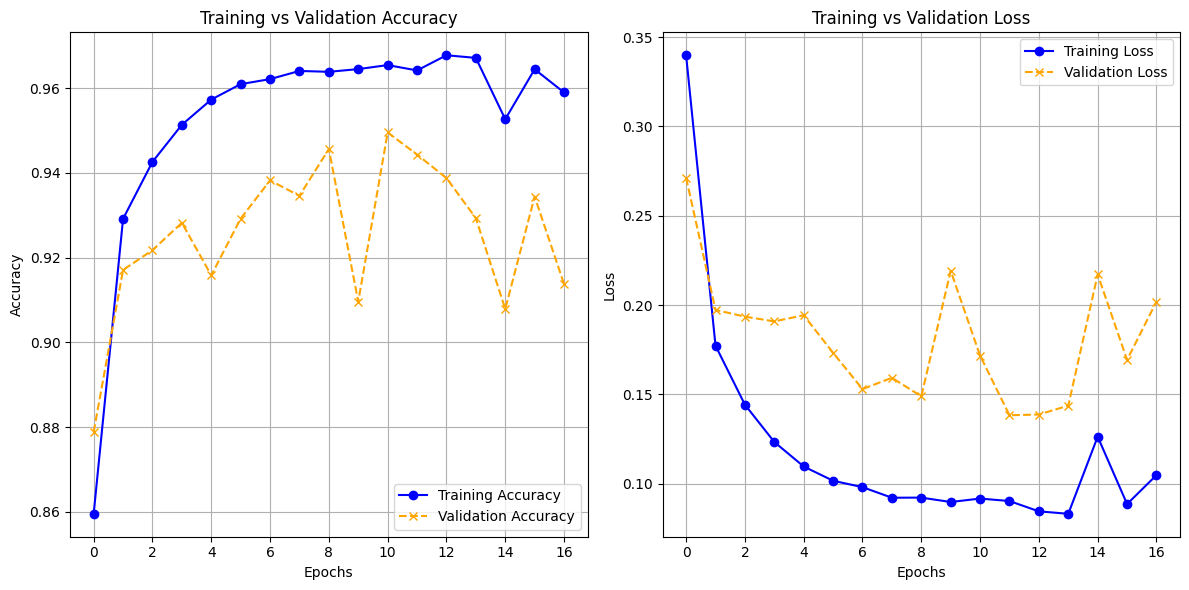

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='x')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(history_df['val_loss'], label='Validation Loss', color='orange', linestyle='--', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set.
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy:.2f}")

341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9291 - loss: 0.1880
Test Accuracy: 0.93


In [ ]:
model.save('deepfake_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('deepfake_model.keras')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,544,165 (51.67 MB)

 Trainable params: 4,514,721 (17.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,029,444 (34.44 MB)

## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

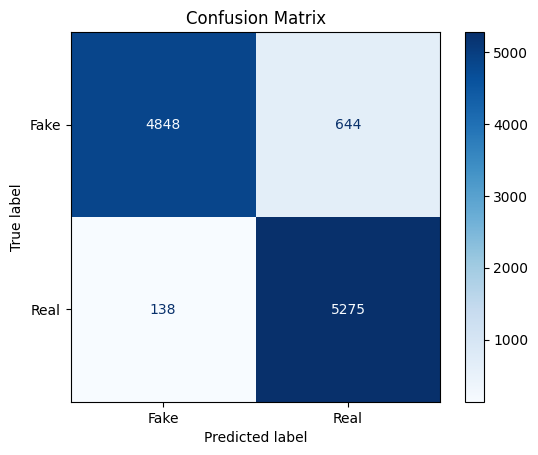

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
predictions = []

for images, labels in test:
    true_labels.extend(labels.numpy())
    batch_predictions = model.predict(images) >= 0.5
    predictions.extend(batch_predictions.astype(int).flatten())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Confusion matrix.
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Classification Report

In [ ]:
# Classification report
from sklearn.metrics import classification_report

print("Classification Report:")
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)


Classification Report:
              precision    recall  f1-score   support

        Fake       0.97      0.88      0.93      5492
        Real       0.89      0.97      0.93      5413

    accuracy                           0.93     10905
   macro avg       0.93      0.93      0.93     10905
weighted avg       0.93      0.93      0.93     10905



## Testing the Model: Visualizing Predictions vs True Labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


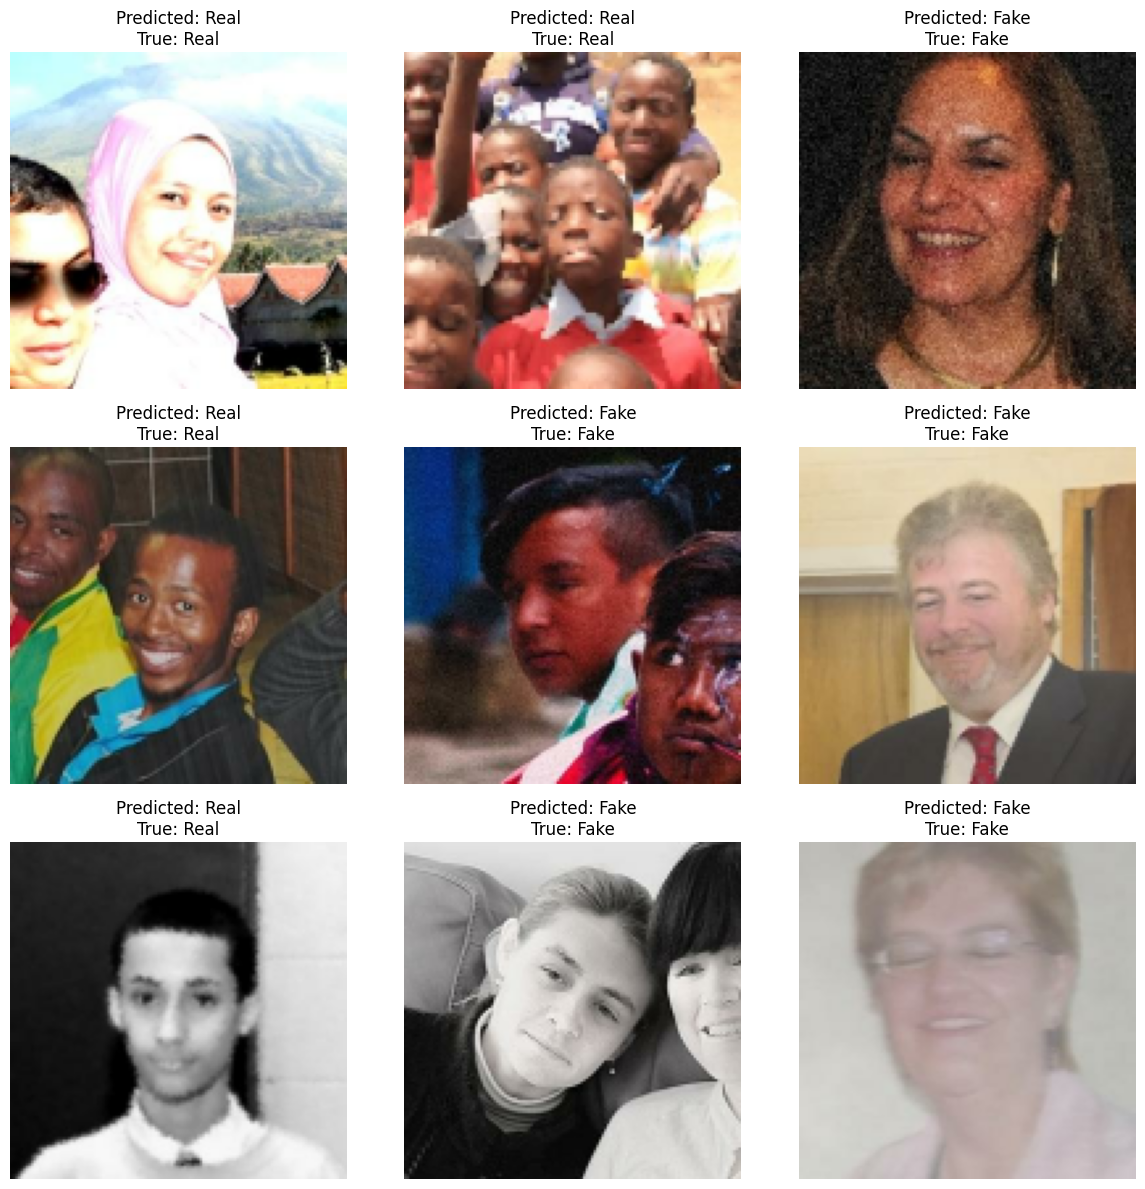

In [ ]:
# Visualize predictions vs true labels
test_images, test_labels = next(iter(test.take(2)))  # Take a single batch for visualization
predictions = model.predict(test_images) >= 0.5
predicted_classes = predictions.astype(int).flatten()

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {class_names[predicted_classes[i]]}\nTrue: {class_names[test_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()